In [1]:
%pylab inline
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load monkey FI excitatory neurons data...

In [2]:
insData = sc.read('../data_h5/Inhib_sorted.h5ad')
insData

AnnData object with n_obs × n_vars = 16364 × 19944
    obs: 'batch', 'doublet_score', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'sampleLayers', 'cluster_labels', 'Sex', 'mainMarker'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sex_colors', 'batch_colors', 'cluster_labels_colors', 'cluster_names', 'hvg', 'leiden', 'leiden_colors', 'mainMarker_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sampleLayers_colors', 'tsne', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_tsne', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'

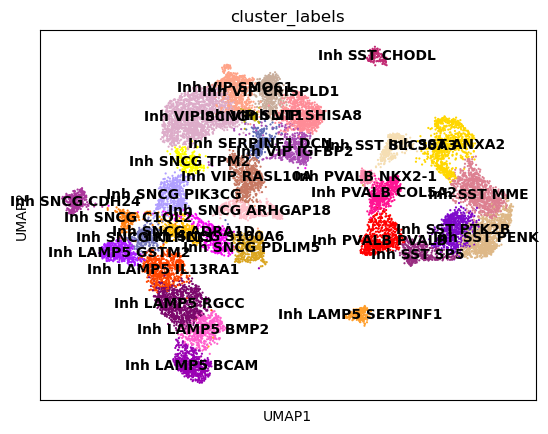

In [3]:
sc.pl.umap(insData,color=['cluster_labels'], legend_loc='on data', size=10)

In [4]:
insData.layers['RawCounts']

<16364x19944 sparse matrix of type '<class 'numpy.float32'>'
	with 57000868 stored elements in Compressed Sparse Row format>

In [5]:
ins_adata=sc.AnnData(insData.layers['RawCounts'],dict(obs_names=insData.obs_names),dict(var_names=insData.var_names))
ins_adata.obs['batch'] = insData.obs['batch']
ins_adata.obs['brainArea'] = 'Ins'
ins_adata.obs['species'] = 'monkey'
ins_adata.obs['cellTypeID'] = insData.obs['leiden']
ins_adata.obs['cellType_labels'] = insData.obs['cluster_labels']
# ins_adata.obs['Sex'] = insData.obs['Sex']
# ins_adata.obs['Sample'] = insData.obs['Sample']
# ins_adata.obs['cellTypeID_2'] = insData.obs['cellTypeID_2']
# ins_adata.obs['cellType_labels_2'] = insData.obs['cellType_labels_2']

In [6]:
# load the human counts data...
MTG_adata0 = sc.read('./HodgeData/Hodge_MTG.h5ad')

In [7]:
MTG_adata = sc.AnnData(MTG_adata0.layers['rawCounts'],dict(obs_names=MTG_adata0.obs_names),dict(var_names=MTG_adata0.var_names))
# MTG_adata = MTG_adata0[~MTG_adat0a.obs['class'].isin(['Non-neuronal']),]
# MTG_adata.X = MTG_adata0.layers['rawCounts']
MTG_adata.obs['class'] = MTG_adata0.obs['class']
MTG_adata.obs['subclass'] = MTG_adata0.obs['subclass']
MTG_adata.obs['cluster'] = MTG_adata0.obs['cluster']
MTG_adata.obs['total_counts_mt'] = MTG_adata0.obs['total_counts_mt']
MTG_adata.obs['pct_counts_mt'] = MTG_adata0.obs['pct_counts_mt']

MTG_adata.obs['species'] = 'human'
MTG_adata.obs['brainArea'] = 'MTG'

In [8]:
MTG_adata

AnnData object with n_obs × n_vars = 15603 × 50281
    obs: 'class', 'subclass', 'cluster', 'total_counts_mt', 'pct_counts_mt', 'species', 'brainArea'

In [9]:
ins_adata

AnnData object with n_obs × n_vars = 16364 × 19944
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellType_labels'

In [10]:
MTG_adata.obs['class']

F1S4_160106_001_B01        GABAergic
F1S4_160106_001_C01    Glutamatergic
F1S4_160106_001_E01    Glutamatergic
F1S4_160106_001_G01    Glutamatergic
F1S4_160106_001_H01    Glutamatergic
                           ...      
F2S4_170405_060_B01    Glutamatergic
F2S4_170405_060_C01    Glutamatergic
F2S4_170405_060_E01    Glutamatergic
F2S4_170405_060_F01        GABAergic
F2S4_170405_060_H01        GABAergic
Name: class, Length: 15603, dtype: category
Categories (3, object): ['GABAergic', 'Glutamatergic', 'Non-neuronal']

In [11]:
# only select the excitatory neurons.
MTG_adata = MTG_adata[MTG_adata.obs['class']=='GABAergic']

In [12]:
adata = ins_adata.concatenate(MTG_adata,index_unique = None)
adata.var['mt'] = adata.var_names.isin(["ND1","ND2","COX1","COX2","COX3","ATP6","ATP8","ND3","ND4","ND5","ND6","ND4L","CYTB"])

In [13]:
adata.write('./data_tem/tem_Inhitory_integrated_ins_vs_MTG_step1.h5ad')

# integrate the datasets and compare the clusters...

In [14]:
# adata = sc.read('./data_tem/tem_Inhitory_integrated_ins_vs_MTG_step1.h5ad')

In [15]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    batch_key="batch",
    flavor="seurat",
    n_top_genes=2500,
    subset=True,
    min_mean=0.015, 
    max_mean=10,
    min_disp=0.05
)

In [16]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 20528 × 2500
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellType_labels', 'class', 'subclass', 'cluster', 'total_counts_mt', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'

In [17]:
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

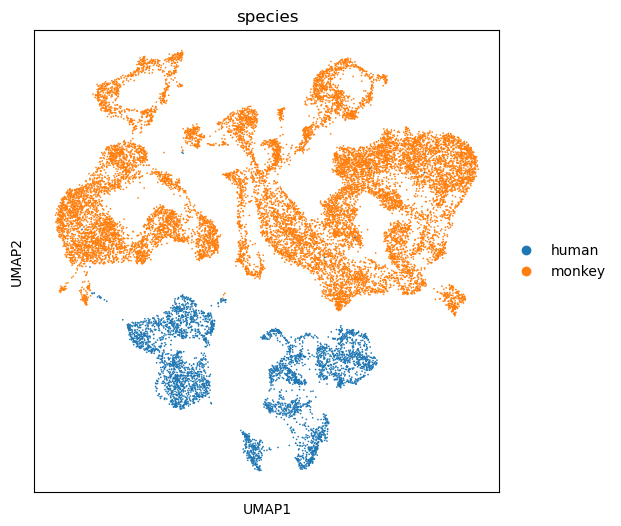

In [18]:
figsize(6,6)
sc.pl.umap(adata,color=['species'])

## Integrate with harmoney

In [19]:
import harmonypy as hm
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, ['batch','species'],theta=10,max_iter_harmony=10,max_iter_kmeans=20)

adata.obsm['X_harmonypca'] = ho.Z_corr.T
sc.pp.neighbors(adata, use_rep='X_harmonypca',n_neighbors=10, n_pcs=40)

adata.obsm['X_umapraw'] = adata.obsm['X_umap']
sc.tl.umap(adata)
adata.obsm['X_umapharmony'] = adata.obsm['X_umap']

2025-03-01 13:08:15,432 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-01 13:08:24,461 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-01 13:08:24,530 - harmonypy - INFO - Iteration 1 of 10
2025-03-01 13:08:32,433 - harmonypy - INFO - Iteration 2 of 10
2025-03-01 13:08:37,966 - harmonypy - INFO - Iteration 3 of 10
2025-03-01 13:08:43,836 - harmonypy - INFO - Iteration 4 of 10
2025-03-01 13:08:49,010 - harmonypy - INFO - Iteration 5 of 10
2025-03-01 13:08:53,185 - harmonypy - INFO - Iteration 6 of 10
2025-03-01 13:08:55,348 - harmonypy - INFO - Iteration 7 of 10
2025-03-01 13:08:57,857 - harmonypy - INFO - Iteration 8 of 10
2025-03-01 13:09:01,816 - harmonypy - INFO - Iteration 9 of 10
2025-03-01 13:09:06,056 - harmonypy - INFO - Iteration 10 of 10
2025-03-01 13:09:09,102 - harmonypy - INFO - Stopped before convergence


In [20]:
adata

AnnData object with n_obs × n_vars = 20528 × 2500
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellType_labels', 'class', 'subclass', 'cluster', 'total_counts_mt', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'species_colors'
    obsm: 'X_pca', 'X_umap', 'X_harmonypca', 'X_umapraw', 'X_umapharmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

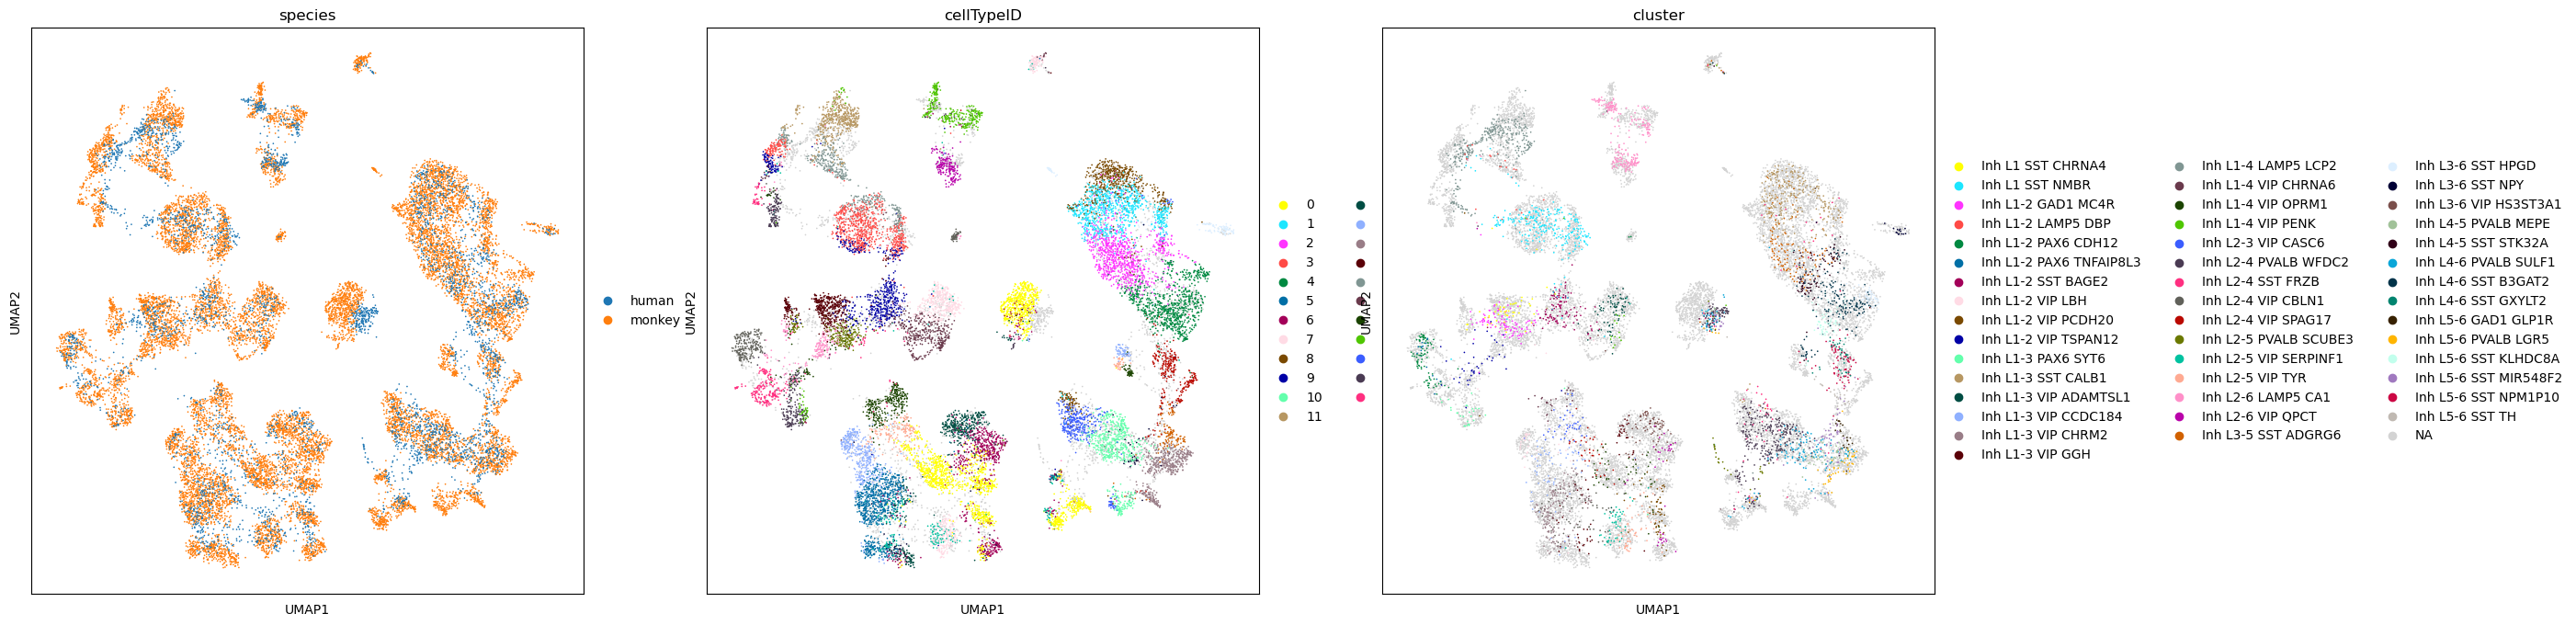

In [21]:
figsize(8,8)
sc.pl.umap(adata,color=['species','cellTypeID','cluster'])

In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pylab inline
import sys
sys.path.append('../tools')
from two_species_heatmap import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [23]:
sc.pp.neighbors(adata,  metric='euclidean',use_rep = 'X_harmonypca' )
sc.tl.louvain(adata, resolution = 1.8, key_added = 'louvain')
adata.obs['louvain_1_8'] = adata.obs['louvain']

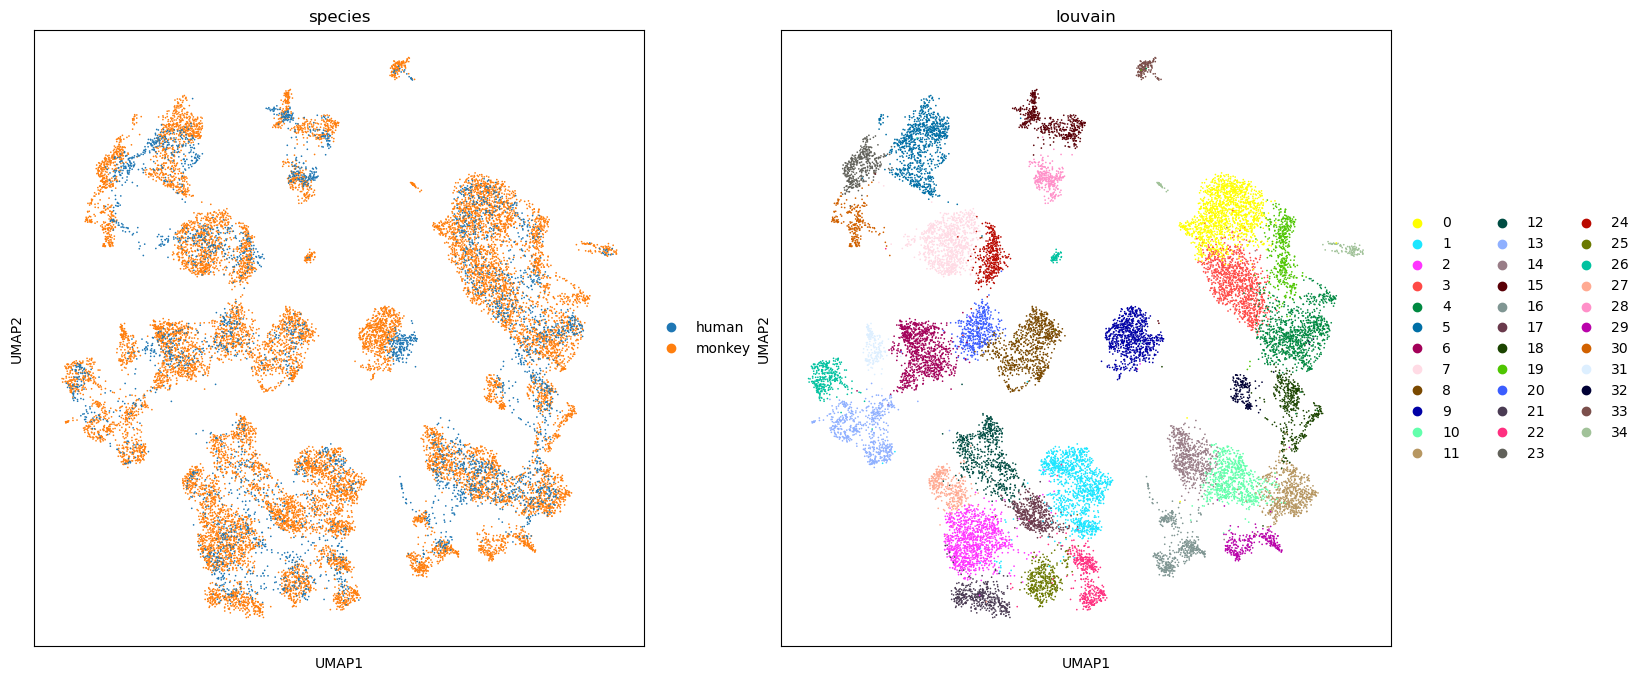

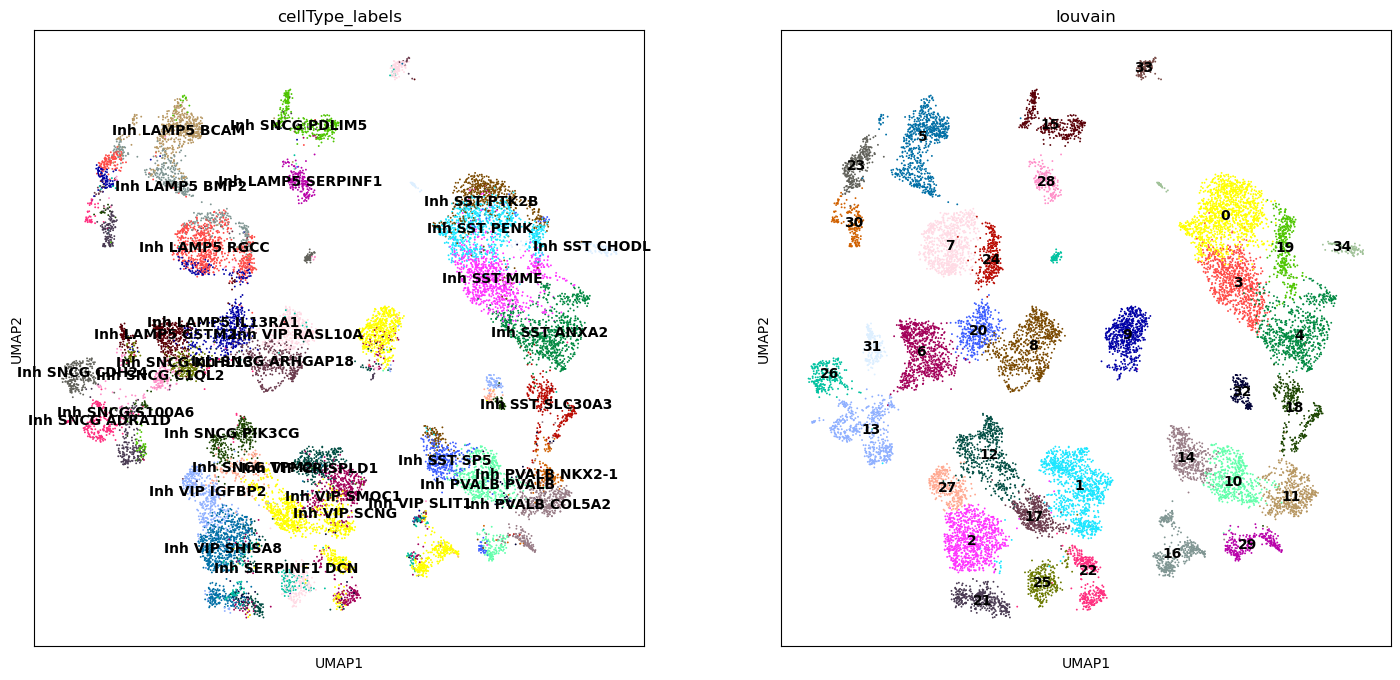

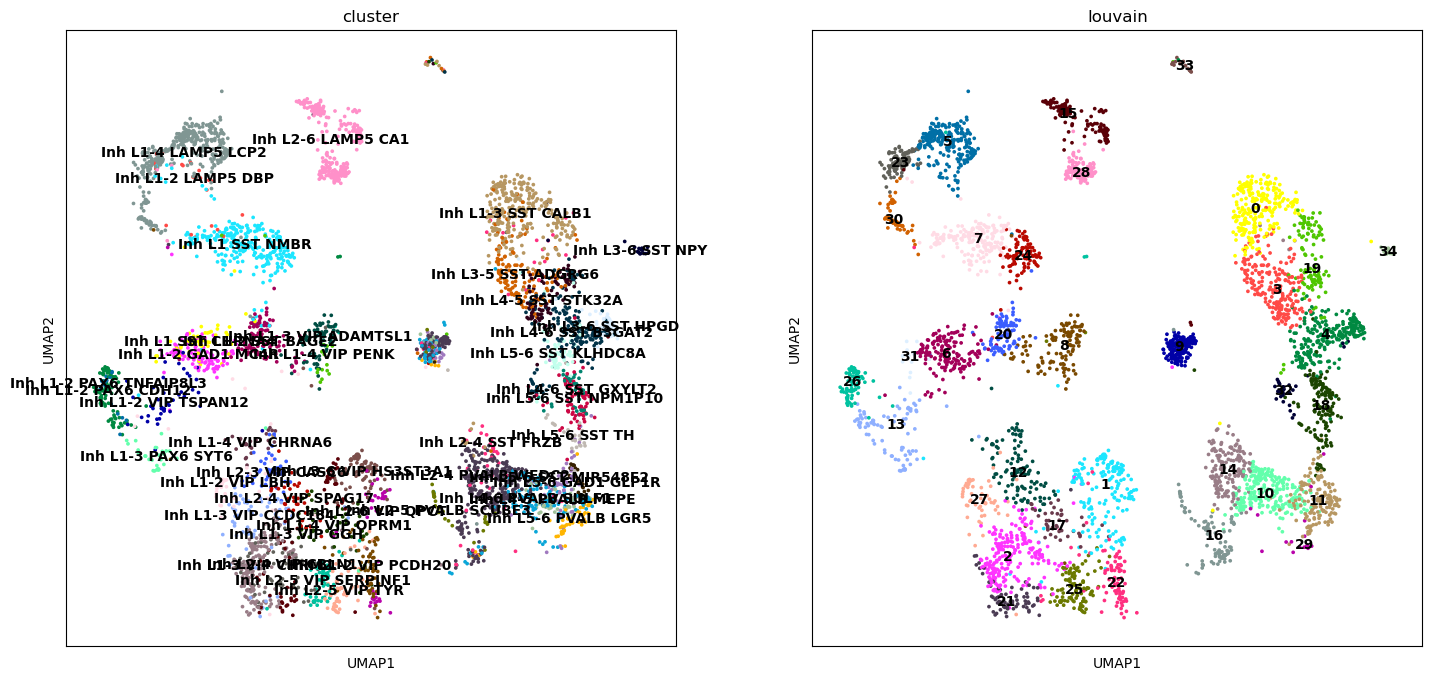

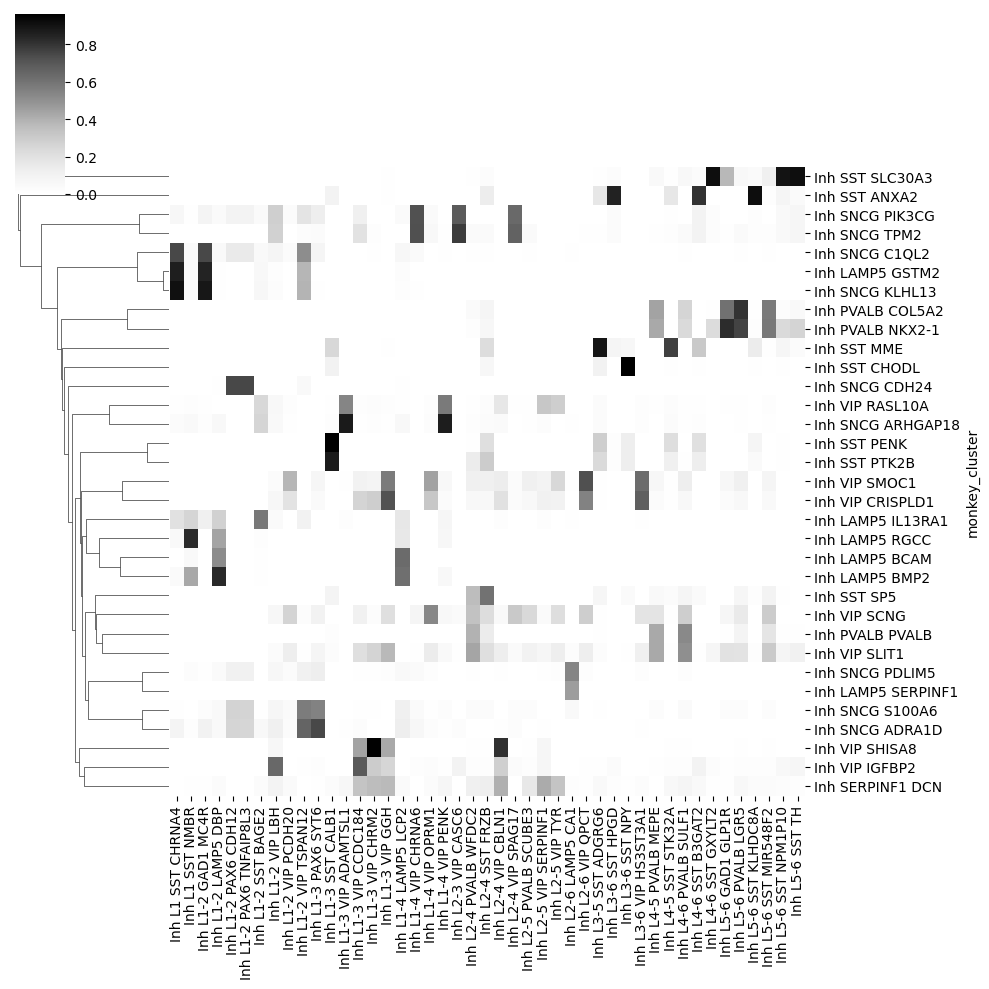

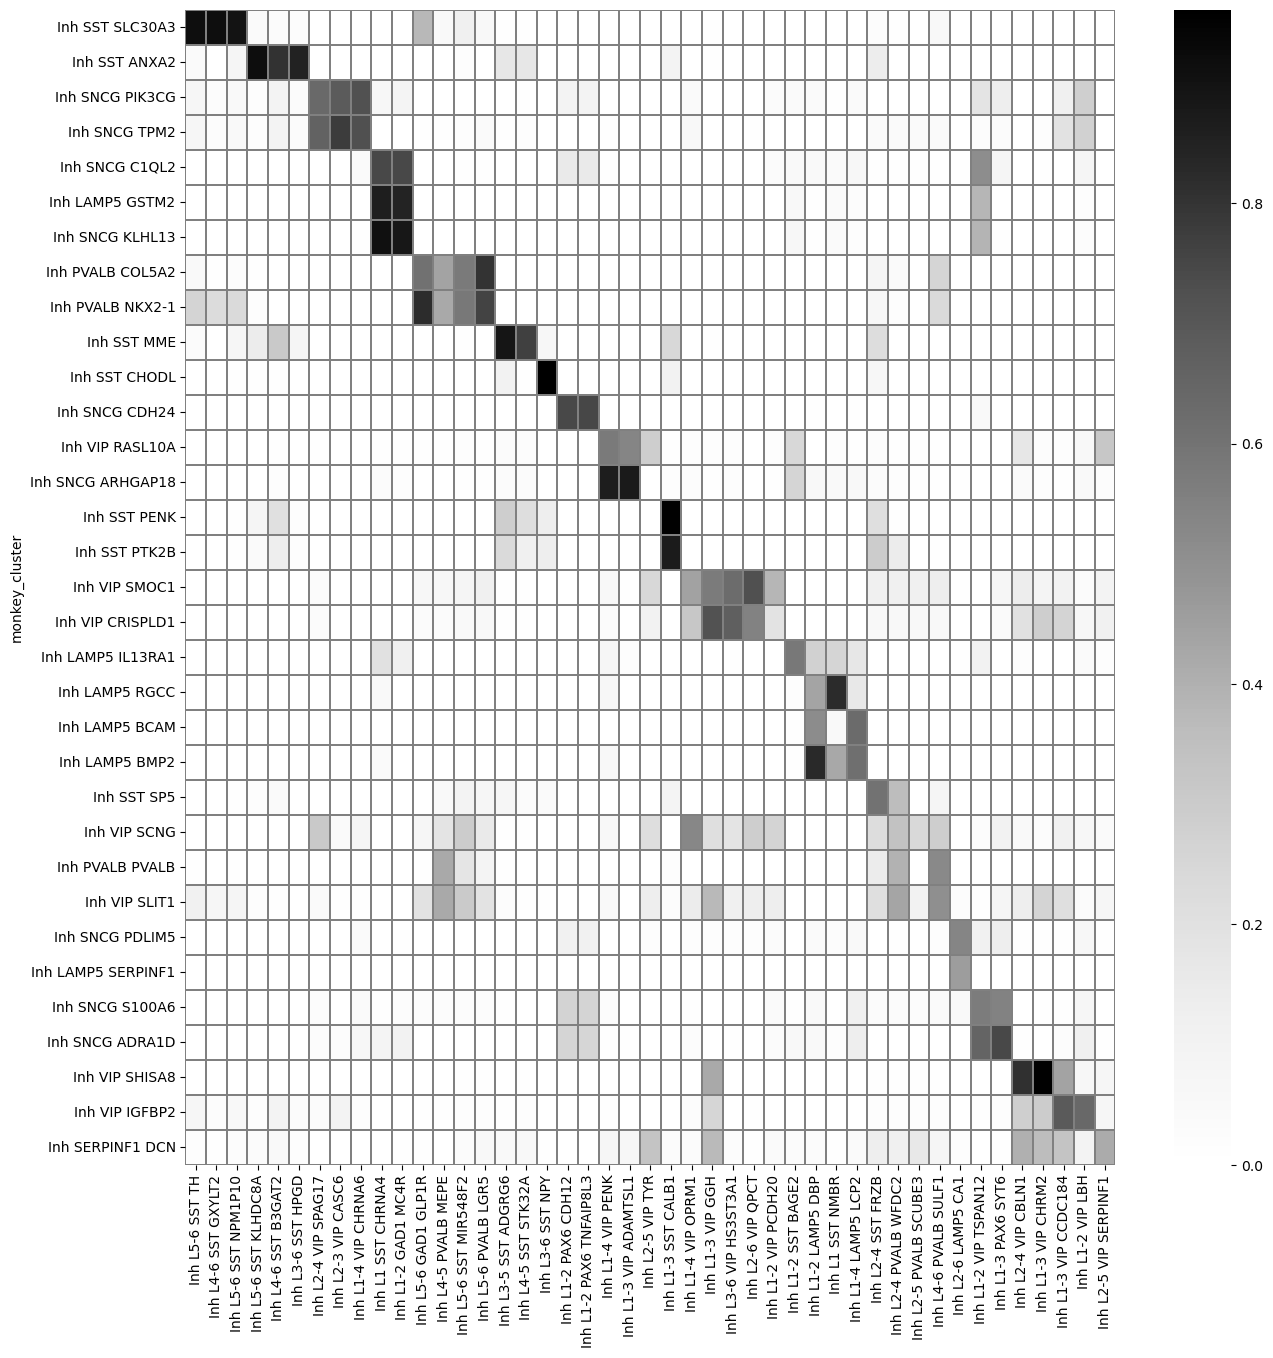

In [24]:
plot_GliaMatrix_ins_vs_v1_lovain_1_8 = two_species_heatmap(adata, species_1 = 'monkey', species_2 = 'human',\
                species_1_key = 'cellType_labels', species_2_key = 'cluster',\
                louvain = 1.8)#,figure_path = 'neurons_heatmap_cmp.png')

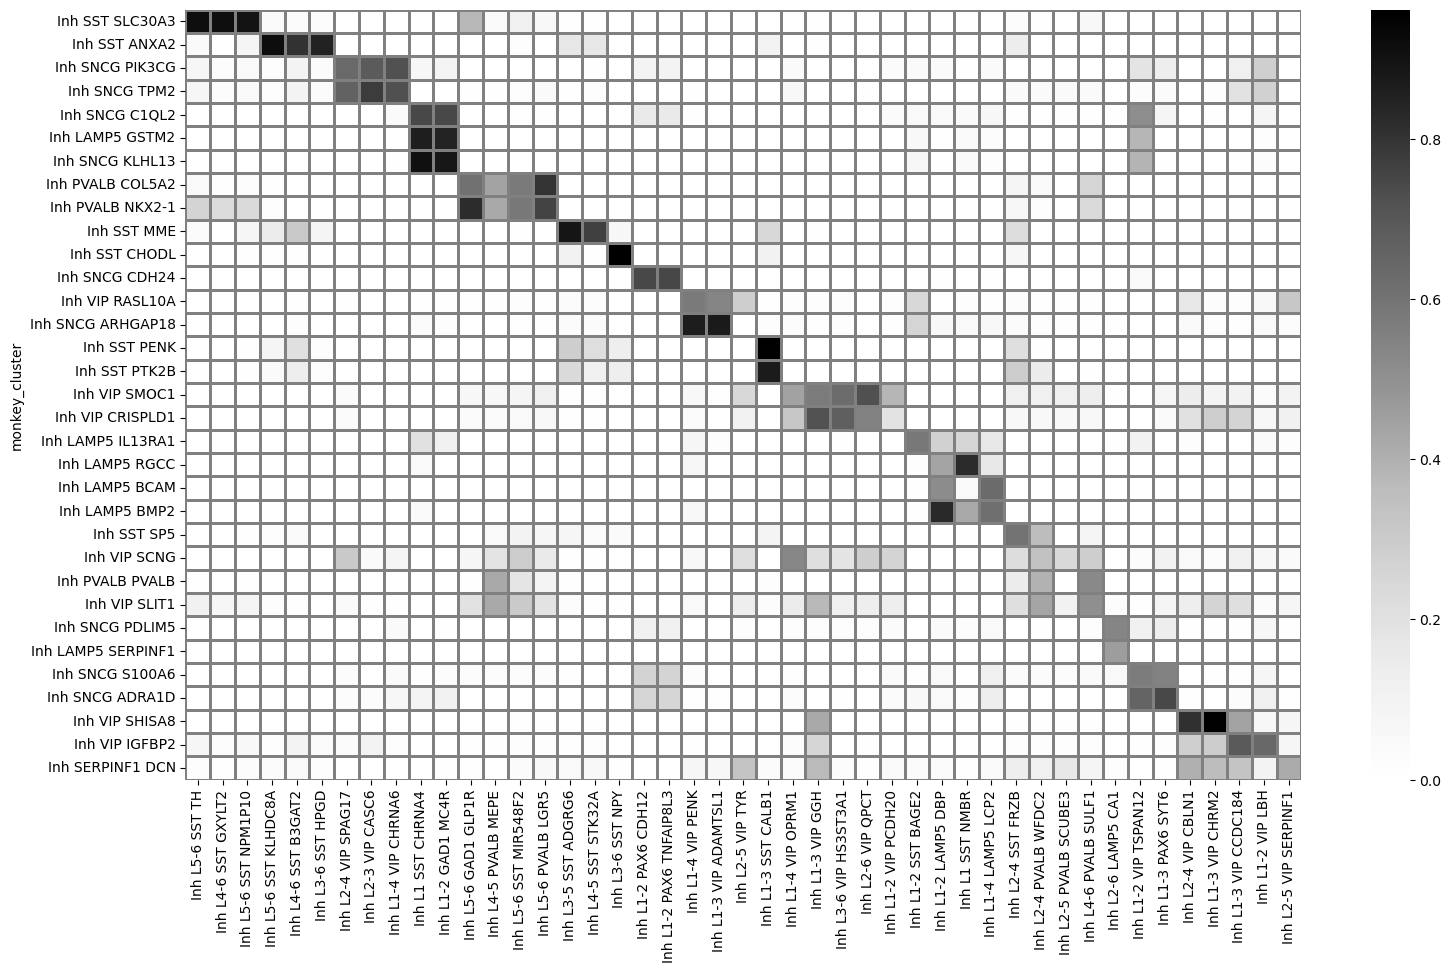

In [25]:
plt.figure(figsize = (18,10))
sns_plot = sns.heatmap(plot_GliaMatrix_ins_vs_v1_lovain_1_8, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 1, linecolor = 'gray')

In [26]:
adata.uns['df_clusterCmpMatrix_louvain_1_8'] = plot_GliaMatrix_ins_vs_v1_lovain_1_8

In [27]:
adata.write('./data_tem/integrated_Inhibitory_ins_vs_MTG_final.h5ad',compression='gzip')

In [28]:
### plot figures

In [29]:
plot_GliaMatrix_ins_vs_v1_lovain_1_8.index

Index(['Inh SST SLC30A3', 'Inh SST ANXA2', 'Inh SNCG PIK3CG', 'Inh SNCG TPM2',
       'Inh SNCG C1QL2', 'Inh LAMP5 GSTM2', 'Inh SNCG KLHL13',
       'Inh PVALB COL5A2', 'Inh PVALB NKX2-1', 'Inh SST MME', 'Inh SST CHODL',
       'Inh SNCG CDH24', 'Inh VIP RASL10A', 'Inh SNCG ARHGAP18',
       'Inh SST PENK', 'Inh SST PTK2B', 'Inh VIP SMOC1', 'Inh VIP CRISPLD1',
       'Inh LAMP5 IL13RA1', 'Inh LAMP5 RGCC', 'Inh LAMP5 BCAM',
       'Inh LAMP5 BMP2', 'Inh SST SP5', 'Inh VIP SCNG', 'Inh PVALB PVALB',
       'Inh VIP SLIT1', 'Inh SNCG PDLIM5', 'Inh LAMP5 SERPINF1',
       'Inh SNCG S100A6', 'Inh SNCG ADRA1D', 'Inh VIP SHISA8',
       'Inh VIP IGFBP2', 'Inh SERPINF1 DCN'],
      dtype='object', name='monkey_cluster')

In [30]:
plot_GliaMatrix_ins_vs_v1_lovain_1_8.columns

Index(['Inh L5-6 SST TH', 'Inh L4-6 SST GXYLT2', 'Inh L5-6 SST NPM1P10',
       'Inh L5-6 SST KLHDC8A', 'Inh L4-6 SST B3GAT2', 'Inh L3-6 SST HPGD',
       'Inh L2-4 VIP SPAG17', 'Inh L2-3 VIP CASC6', 'Inh L1-4 VIP CHRNA6',
       'Inh L1 SST CHRNA4', 'Inh L1-2 GAD1 MC4R', 'Inh L5-6 GAD1 GLP1R',
       'Inh L4-5 PVALB MEPE', 'Inh L5-6 SST MIR548F2', 'Inh L5-6 PVALB LGR5',
       'Inh L3-5 SST ADGRG6', 'Inh L4-5 SST STK32A', 'Inh L3-6 SST NPY',
       'Inh L1-2 PAX6 CDH12', 'Inh L1-2 PAX6 TNFAIP8L3', 'Inh L1-4 VIP PENK',
       'Inh L1-3 VIP ADAMTSL1', 'Inh L2-5 VIP TYR', 'Inh L1-3 SST CALB1',
       'Inh L1-4 VIP OPRM1', 'Inh L1-3 VIP GGH', 'Inh L3-6 VIP HS3ST3A1',
       'Inh L2-6 VIP QPCT', 'Inh L1-2 VIP PCDH20', 'Inh L1-2 SST BAGE2',
       'Inh L1-2 LAMP5 DBP', 'Inh L1 SST NMBR', 'Inh L1-4 LAMP5 LCP2',
       'Inh L2-4 SST FRZB', 'Inh L2-4 PVALB WFDC2', 'Inh L2-5 PVALB SCUBE3',
       'Inh L4-6 PVALB SULF1', 'Inh L2-6 LAMP5 CA1', 'Inh L1-2 VIP TSPAN12',
       'Inh L1-3 PAX6 SYT6', 

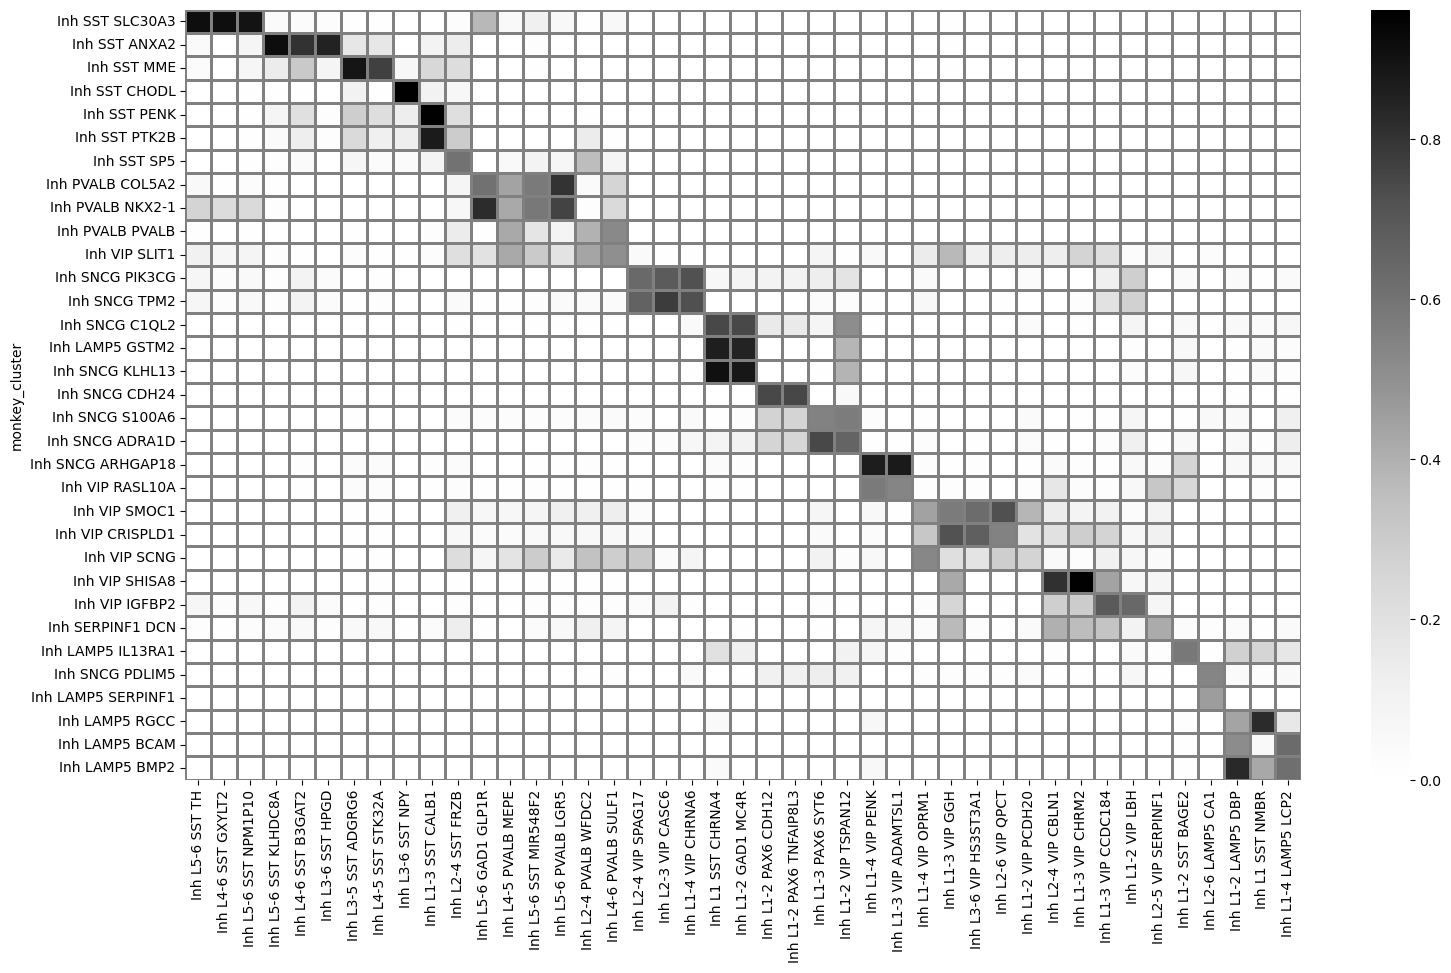

In [31]:
index_order = ['Inh SST SLC30A3',                               # SST
               'Inh SST ANXA2',                                # SST
               'Inh SST MME',                                  # SST
               'Inh SST CHODL',
               'Inh SST PENK', 'Inh SST PTK2B',
               'Inh SST SP5', 
               
               'Inh PVALB COL5A2', 'Inh PVALB NKX2-1',            # PVALB
                'Inh PVALB PVALB', 'Inh VIP SLIT1',               # PVALB
               
               'Inh SNCG PIK3CG', 'Inh SNCG TPM2',                             # SNCG
               'Inh SNCG C1QL2', 'Inh LAMP5 GSTM2', 'Inh SNCG KLHL13',                        # SNCG
               'Inh SNCG CDH24',                                               # SNCG
               'Inh SNCG S100A6', 'Inh SNCG ADRA1D',
               
               'Inh SNCG ARHGAP18', 'Inh VIP RASL10A',             #  VIP
               'Inh VIP SMOC1', 'Inh VIP CRISPLD1', 'Inh VIP SCNG',                #  VIP
               'Inh VIP SHISA8',  'Inh VIP IGFBP2', 'Inh SERPINF1 DCN',                #  VIP
               
               'Inh LAMP5 IL13RA1',                                           #  LAMP5
               'Inh SNCG PDLIM5', 'Inh LAMP5 SERPINF1',                                #  LAMP5
               'Inh LAMP5 RGCC', 'Inh LAMP5 BCAM', 'Inh LAMP5 BMP2', ]                                 #  LAMP5
                
column_order = ['Inh L5-6 SST TH', 'Inh L4-6 SST GXYLT2', 'Inh L5-6 SST NPM1P10',
                'Inh L5-6 SST KLHDC8A', 'Inh L4-6 SST B3GAT2', 'Inh L3-6 SST HPGD',
                'Inh L3-5 SST ADGRG6', 'Inh L4-5 SST STK32A',
                'Inh L3-6 SST NPY',
                'Inh L1-3 SST CALB1',
                'Inh L2-4 SST FRZB', 
                
                'Inh L5-6 GAD1 GLP1R', 'Inh L4-5 PVALB MEPE', 'Inh L5-6 SST MIR548F2', 'Inh L5-6 PVALB LGR5',             # PVALB  
                'Inh L2-4 PVALB WFDC2', 'Inh L4-6 PVALB SULF1',
                
                'Inh L2-4 VIP SPAG17', 'Inh L2-3 VIP CASC6', 'Inh L1-4 VIP CHRNA6',                         # SNCG      
                'Inh L1 SST CHRNA4', 'Inh L1-2 GAD1 MC4R',                                             # SNCG 
                'Inh L1-2 PAX6 CDH12', 'Inh L1-2 PAX6 TNFAIP8L3',                                          # SNCG 
                'Inh L1-3 PAX6 SYT6', 'Inh L1-2 VIP TSPAN12',                                             # SNCG        
                
                'Inh L1-4 VIP PENK', 'Inh L1-3 VIP ADAMTSL1', 
                'Inh L1-4 VIP OPRM1', 'Inh L1-3 VIP GGH', 'Inh L3-6 VIP HS3ST3A1', 'Inh L2-6 VIP QPCT', 'Inh L1-2 VIP PCDH20',        # VIP
                'Inh L2-4 VIP CBLN1', 'Inh L1-3 VIP CHRM2','Inh L1-3 VIP CCDC184', 'Inh L1-2 VIP LBH', 'Inh L2-5 VIP SERPINF1',
                
                'Inh L1-2 SST BAGE2',
                'Inh L2-6 LAMP5 CA1',  
                'Inh L1-2 LAMP5 DBP', 'Inh L1 SST NMBR', 'Inh L1-4 LAMP5 LCP2', ]                #  'Inh L2-5 VIP TYR',   'Inh L2-5 PVALB SCUBE3',
               
plot_GliaMatrix_ins_vs_v1_lovain_1_8 = plot_GliaMatrix_ins_vs_v1_lovain_1_8.reindex(index=index_order, columns=column_order)

plt.figure(figsize = (18,10))
sns_plot = sns.heatmap(plot_GliaMatrix_ins_vs_v1_lovain_1_8, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 1, linecolor = 'gray')
plt.savefig('figures/inhibitory_cmpMatrix_mkIns_vs_hodgeMTG_2500VirableGenes.pdf',dpi = 600, )